# Imports and technical setup

In [1]:
from pathlib import Path
persist_path = Path('..') / 'persist'
import pandas as pd
from pandas import IndexSlice as idx
from IPython.display import display
import matplotlib.pyplot as plt
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
import scripts.utils as utils
from bokeh.io import output_notebook, show
output_notebook()
from functools import partial

Loading BokehJS ...

# Construction d'un indicateur "taux de web"

In [2]:
orders = pd.read_pickle(persist_path / 'orders.pkl')
# orders

In [3]:
day_orders = pd.read_pickle(persist_path / 'day_order.pkl')
# day_orders

In [4]:
%%time
day_orders = (
    day_orders.join(
        pd.concat([day_orders.groupby('indicators', axis=1).sum()], keys=['total'], axis=1).swaplevel(axis=1)
    ).sort_index(axis=1)
)
# day_orders

CPU times: user 12.9 s, sys: 8.95 s, total: 21.8 s
Wall time: 21.8 s


In [5]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

In [8]:
%%time
rolled = (
utils.compute_rolling_percentage(
    data=day_orders,
    window=200, 
    win_type='triang',
    indicator='brutrevenue',
    axis='WEB',
    roll_kwargs=dict(center=True),
    groupers=['orgacom', 'client'],
).rename('percentage')
)

CPU times: user 1min 6s, sys: 3.18 s, total: 1min 9s
Wall time: 1min 9s


1ALO 0000020531


,origin2,brutrevenue
date,,
2017-08-29,VR,422.90
2017-09-26,TV,386.62
2017-10-03,VR,772.00
2017-10-13,TV,317.60
2017-11-07,TV,201.92
2017-11-14,VR,166.20
2017-11-17,TV,10.94
2017-11-24,TV,1017.43
2017-11-28,VR,296.49


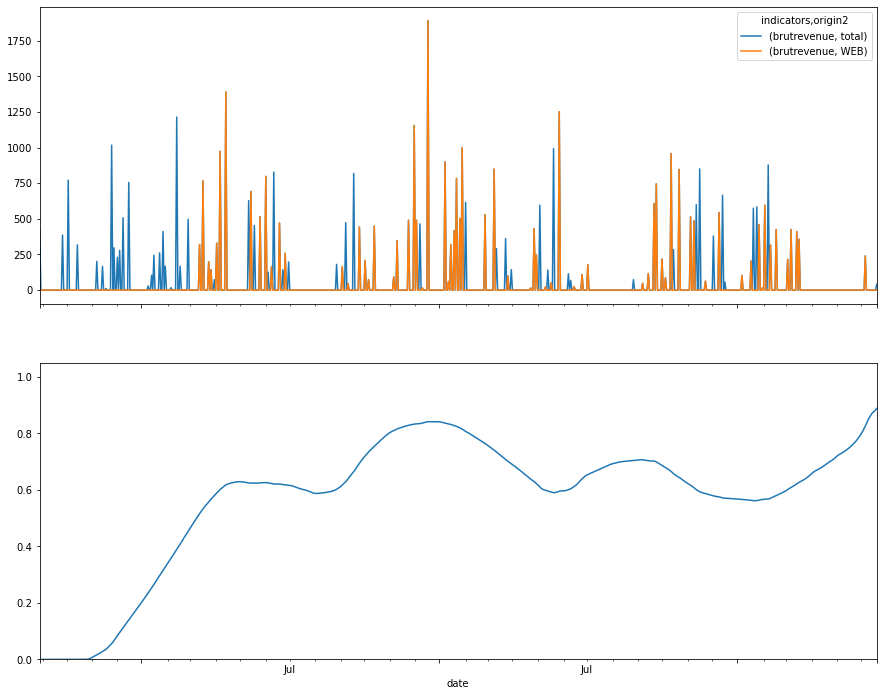

In [60]:
oc, clt = '1ALO', '0000020575'
oc, clt = '1ALO', '0000020531'

# oc, clt = list(rolled.loc[rolled != 0]
#                      .index.to_frame()
#                      .loc[lambda x: x.client.str[0] != 'P', ['orgacom', 'client']].drop_duplicates().sample(1).iloc[0])
fig, axs = plt.subplots(nrows=2, figsize=(15, 12), sharex=True)
day_orders.loc[(oc, clt), [('brutrevenue', 'total'), ('brutrevenue', 'WEB')]].plot(kind='line', ax=axs[0])
rolled.loc[(oc, clt)].plot(kind='line', ax=axs[1])
# ax.set_xlim(pd.to_datetime('2018-03-01'), pd.to_datetime('2018-05-31'))
axs[0].set_xticklabels([])
axs[1].set_ylim(0, 1.05)
print(oc, clt)
with pd.option_context('display.max_rows', None):
    display(orders.loc[(oc, clt), ['origin2', 'brutrevenue', ]])

In [62]:
with pd.option_context('display.max_rows', None):
    display(
pd.cut(rolled.loc[(oc, clt)], bins=[0., .2, .5, .9, 1.1], labels=['no_web', 'adopt', 'exploit', 'exclusive'], right=False)
#     .loc[lambda x: x=='exploit']
)

date
2017-08-29     no_web
2017-08-30     no_web
2017-08-31     no_web
2017-09-01     no_web
2017-09-04     no_web
2017-09-05     no_web
2017-09-06     no_web
2017-09-07     no_web
2017-09-08     no_web
2017-09-11     no_web
2017-09-12     no_web
2017-09-13     no_web
2017-09-14     no_web
2017-09-15     no_web
2017-09-18     no_web
2017-09-19     no_web
2017-09-20     no_web
2017-09-21     no_web
2017-09-22     no_web
2017-09-25     no_web
2017-09-26     no_web
2017-09-27     no_web
2017-09-28     no_web
2017-09-29     no_web
2017-10-02     no_web
2017-10-03     no_web
2017-10-04     no_web
2017-10-05     no_web
2017-10-06     no_web
2017-10-09     no_web
2017-10-10     no_web
2017-10-11     no_web
2017-10-12     no_web
2017-10-13     no_web
2017-10-16     no_web
2017-10-17     no_web
2017-10-18     no_web
2017-10-19     no_web
2017-10-20     no_web
2017-10-23     no_web
2017-10-24     no_web
2017-10-25     no_web
2017-10-26     no_web
2017-10-27     no_web
2017-10-30     no_web
2017-

In [59]:
(
pd.cut(rolled, bins=[0., .2, .5, .9, 1.1], labels=['no_web', 'adopt', 'exploit', 'exclusive'], right=False)
    .loc[lambda x: x=='exploit']
)

orgacom  client      date      
1ALO     0000020531  2018-03-09    exploit
                     2018-03-12    exploit
                     2018-03-13    exploit
                     2018-03-14    exploit
                     2018-03-15    exploit
                                    ...   
2BRE     P044754     2020-02-25    exploit
                     2020-02-26    exploit
                     2020-02-27    exploit
                     2020-02-28    exploit
                     2020-03-02    exploit
Length: 371723, dtype: category
Categories (4, object): ['no_web' < 'adopt' < 'exploit' < 'exclusive']

In [52]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

In [53]:
show(partial(utils.bk_detail,
             data=orders.reset_index().loc[
#                  (orders.reset_index().date >= pd.to_datetime('2017-01-01')) &
#                  (orders.reset_index().date <= pd.to_datetime('2019-12-31')) &
                 (orders.reset_index().client == clt)
             ],
             rolled=rolled.rename('percentage').loc[(oc, clt)].reset_index(),
             client=clt,
            ),
     notebook_url="http://devdm:8888")

In [ ]:
utils.bk_detail()

In [125]:
test = day_orders.loc[('1ALO', '0000020555'), [('brutrevenue', 'WEB'), ('brutrevenue', 'total')]]
test.columns = test.columns.droplevel(level=0)
test2 = test.rolling(30, min_periods=1, win_type='triang').sum()
(test2['WEB'] / test2['total']).fillna(0)

date
2017-09-22    0.0
2017-09-25    0.0
2017-09-26    0.0
2017-09-27    0.0
2017-09-28    0.0
             ... 
2020-08-24    0.0
2020-08-25    0.0
2020-08-26    0.0
2020-08-27    0.0
2020-08-28    0.0
Length: 766, dtype: float64

In [124]:
day_orders.loc[('1ALO', '0000020555')]
rolled.loc[('1ALO', '0000020555')]

date
2017-09-22    0.942517
2017-09-25    0.901079
2017-09-26    0.884415
2017-09-27    0.875421
2017-09-28    0.869792
                ...   
2020-08-24    0.000000
2020-08-25    0.000000
2020-08-26    0.000000
2020-08-27    0.000000
2020-08-28    0.000000
Length: 766, dtype: float64

In [98]:
rolled.loc[(rolled >= 1.)]

orgacom  client      date      
1ALO     0000020531  2018-10-30    1.0
                     2018-10-31    1.0
                     2018-11-01    1.0
                     2018-11-02    1.0
                     2018-11-05    1.0
                                  ... 
2BRE     P045188     2020-07-27    1.0
                     2020-07-28    1.0
                     2020-07-29    1.0
                     2020-07-30    1.0
                     2020-07-31    1.0
Length: 370327, dtype: float64

In [7]:
rolled.loc[rolled != 0].index.get_level_values(1).unique()[:30]

Index(['0000019720', '0000020511', '0000020531', '0000020534', '0000020545',
       '0000020554', '0000020557', '0000020568', '0000020575', '0000020581',
       '0000020592', '0000020593', '0000020599', '0000020602', '0000020604',
       '0000020611', '0000020614', '0000020661', '0000020674', '0000020677',
       '0000020680', '0000020690', '0000020697', '0000020698', '0000020704',
       '0000020733', '0000020734', '0000020744', '0000020748', '0000020753'],
      dtype='object', name='client')

In [34]:
df = day_orders.loc[:, 'brutrevenue'].copy()
print(df.shape)
print(df.sum(axis=1).shape)
df['total'] = 3 #df.sum(axis=1).rename((indicator, 'total'))
# df = df[(indicator, axis), (indicator, 'total')]
df

(15650027, 4)
(15650027,)


origin2                        EDI       TV   VR  WEB  total
orgacom client     date                                     
1ALO    0000015304 2017-07-03  0.0  1340.95  0.0  0.0      3
                   2017-07-04  0.0   196.54  0.0  0.0      3
                   2017-07-05  0.0   916.78  0.0  0.0      3
                   2017-07-06  0.0    73.36  0.0  0.0      3
                   2017-07-07  0.0    73.17  0.0  0.0      3
...                            ...      ...  ...  ...    ...
2BRE    SL009N     2020-08-26  0.0     0.00  0.0  0.0      3
                   2020-08-27  0.0   629.91  0.0  0.0      3
                   2020-08-28  0.0     0.00  0.0  0.0      3
                   2020-08-31  0.0    75.03  0.0  0.0      3
        SLD008B    2018-09-14  0.0    70.05  0.0  0.0      3

[15650027 rows x 5 columns]

In [26]:
df[('brutrevenue', 'total')] = df.sum(axis=1).rename(('brutrevenue', 'total'))

ValueError: Names should be list-like for a MultiIndex

In [ ]:
%%time
rolled2 = (
    toto.groupby(['orgacom', 'client'], observed=True)
        .transform(lambda x: x.rolling(5, win_type='triang').mean())
)
rolled2

In [51]:
pd.concat(
    [day_orders.loc[idx['2BRE', 'SL008C', :], [('brutrevenue', 'WEB'), ('brutrevenue', 'total')]],
     day_orders.loc[idx['2BRE', 'SL009N', :], [('brutrevenue', 'WEB'), ('brutrevenue', 'total')]],
    ]
).groupby(['orgacom', 'client']).rolling(5, win_type='triang').mean()

indicators                                         brutrevenue              
origin2                                                    WEB         total
orgacom client                                                              
2BRE    SL008C (2BRE, SL008C, 2017-07-11 00:00:00)         NaN           NaN
               (2BRE, SL008C, 2017-07-12 00:00:00)         NaN           NaN
               (2BRE, SL008C, 2017-07-13 00:00:00)         NaN           NaN
               (2BRE, SL008C, 2017-07-14 00:00:00)         NaN           NaN
               (2BRE, SL008C, 2017-07-17 00:00:00)         0.0  1.657880e+02
...                                                        ...           ...
        SL009N (2BRE, SL009N, 2020-08-25 00:00:00)         0.0  9.094947e-14
               (2BRE, SL009N, 2020-08-26 00:00:00)         0.0  9.094947e-14
               (2BRE, SL009N, 2020-08-27 00:00:00)         0.0  1.259820e+02
               (2BRE, SL009N, 2020-08-28 00:00:00)         0.0  1.259820e+02
               (2BRE, SL009N, 2020-08-31 00:00:00)         0.0  1.409880e+02

[1634 rows x 2 columns]

In [32]:
smol_data = day_orders.loc[[('2BRE', 'SL009N', slice(None)), ('2BRE', 'SL008C')]]

/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


IndexError: tuple index out of range

In [28]:
smol_data = day_orders.loc[('2BRE', 'SL009N'), ('2BRE', 'SL008C')]
smol_data[[('brutrevenue', 'WEB'), ('brutrevenue', 'total')]].plot(kind='line')
smol_data.loc[smol_data[('brutrevenue', 'WEB')] != 0]

KeyError: ('2BRE', 'SL008C')

In [20]:
smol_data[('brutrevenue', 'WEB')].rolling(5, win_type='triang').mean()

date
2017-07-04    NaN
2017-07-05    NaN
2017-07-06    NaN
2017-07-07    NaN
2017-07-10    0.0
             ... 
2020-08-25    0.0
2020-08-26    0.0
2020-08-27    0.0
2020-08-28    0.0
2020-08-31    0.0
Name: (brutrevenue, WEB), Length: 825, dtype: float64

<AxesSubplot:xlabel='date'>

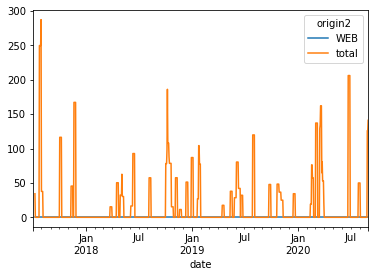

In [12]:
rolled.loc[('2BRE', 'SL009N')].plot(kind='line')

In [26]:
day_orders.loc[('2BRE', 'SL008R')]

indicators brutrevenue                           margin                   \
origin2            EDI      TV   VR  WEB   total    EDI     TV   VR  WEB   
date                                                                       
2017-07-28         0.0  246.18  0.0  0.0  246.18    0.0  19.66  0.0  0.0   
2017-07-31         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2017-08-01         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2017-08-02         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2017-08-03         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
...                ...     ...  ...  ...     ...    ...    ...  ...  ...   
2020-08-17         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2020-08-18         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2020-08-19         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2020-08-20         0.0    0.00  0.0  0.0    0.00    0.0   0.00  0.0  0.0   
2020-08-21         0.0  278.88  0.0  0.0  278.88    0.0  13.73  0.0  0.0   

indicators        weight                          
origin2     total    EDI     TV   VR  WEB  total  
date                                              
2017-07-28  19.66    0.0   51.0  0.0  0.0   51.0  
2017-07-31   0.00    0.0    0.0  0.0  0.0    0.0  
2017-08-01   0.00    0.0    0.0  0.0  0.0    0.0  
2017-08-02   0.00    0.0    0.0  0.0  0.0    0.0  
2017-08-03   0.00    0.0    0.0  0.0  0.0    0.0  
...           ...    ...    ...  ...  ...    ...  
2020-08-17   0.00    0.0    0.0  0.0  0.0    0.0  
2020-08-18   0.00    0.0    0.0  0.0  0.0    0.0  
2020-08-19   0.00    0.0    0.0  0.0  0.0    0.0  
2020-08-20   0.00    0.0    0.0  0.0  0.0    0.0  
2020-08-21  13.73    0.0  525.0  0.0  0.0  525.0  

[801 rows x 15 columns]

In [25]:
day_orders.loc[('2BRE')].index.get_level_values(0).unique()

Index(['0000010047', '0000010055', '0000012435', '0000040582', '0000040621',
       '0000040622', '0000040623', '0000040624', '0000040625', '0000040668',
       ...
       'SL006T', 'SL0073', 'SL0075', 'SL0079', 'SL007S', 'SL008B', 'SL008C',
       'SL008R', 'SL009N', 'SLD008B'],
      dtype='object', name='client', length=8375)

In [82]:
len(to_list[1])

50000

In [134]:
day_orders = day_orders.sort_index()

In [9]:
%time
toto = day_orders.tail(50000).copy()
toto
rolled2 = (
    toto.loc[:, ('brutrevenue', 'WEB')]  # .loc[:, ['WEB', 'total']]
        .groupby(['orgacom', 'client'], observed=True)
        .rolling(5, win_type='triang')
        .mean()    
        .reset_index()
        .drop(['orgacom', 'client'], axis=1)
)

print(rolled2)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.15 µs
                                    level_2   brutrevenue
                                                      WEB
0      (2BRE, P020036, 2019-03-25 00:00:00)           NaN
1      (2BRE, P020036, 2019-03-26 00:00:00)           NaN
2      (2BRE, P020036, 2019-03-27 00:00:00)           NaN
3      (2BRE, P020036, 2019-03-28 00:00:00)           NaN
4      (2BRE, P020036, 2019-03-29 00:00:00)  0.000000e+00
...                                     ...           ...
49995   (2BRE, SL009N, 2020-08-26 00:00:00)  5.684342e-15
49996   (2BRE, SL009N, 2020-08-27 00:00:00)  5.684342e-15
49997   (2BRE, SL009N, 2020-08-28 00:00:00)  5.684342e-15
49998   (2BRE, SL009N, 2020-08-31 00:00:00)  5.684342e-15
49999  (2BRE, SLD008B, 2018-09-14 00:00:00)           NaN

[50000 rows x 2 columns]


/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


indicators                    brutrevenue                                    \
origin2                               EDI          TV   VR  WEB       total   
orgacom client     date                                                       
1ALO    0000015304 2017-07-03         NaN         NaN  NaN  NaN         NaN   
                   2017-07-04         NaN         NaN  NaN  NaN         NaN   
                   2017-07-05         NaN         NaN  NaN  NaN         NaN   
                   2017-07-06         NaN         NaN  NaN  NaN         NaN   
                   2017-07-07         0.0  522.695556  0.0  0.0  522.695556   
...                                   ...         ...  ...  ...         ...   
2BRE    SL009N     2020-08-26         0.0    0.000000  0.0  0.0    0.000000   
                   2020-08-27         0.0   69.990000  0.0  0.0   69.990000   
                   2020-08-28         0.0  139.980000  0.0  0.0  139.980000   
                   2020-08-31         0.0  218.30666

In [17]:
rolled2.loc[rolled2[('brutrevenue', 'WEB')] > 0].index.get_level_values(1).unique()

Index(['0000019720', '0000020511', '0000020531', '0000020534', '0000020545',
       '0000020554', '0000020557', '0000020568', '0000020575', '0000020581',
       ...
       'P042080', 'P043010', 'P043102', 'P043172', 'P043979', 'P044727',
       'P044754', 'P044834', 'P045187', 'P045188'],
      dtype='object', name='client', length=4280)

/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='orgacom,client,date'>

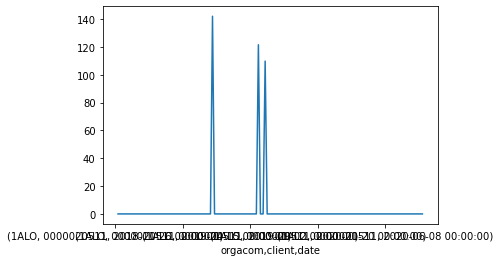

In [23]:
rolled2.loc[idx[:, '0000020511', :], ('brutrevenue', 'WEB')].plot(kind='line')

In [ ]:

# to_list = list(zip(*rolled2.level_2.to_list()))
# rolled2['orgacom'] = to_list[0]
# rolled2['client'] = to_list[1]
# rolled2['date'] = to_list[2]
# rolled2 = rolled2.drop('level_2', axis=1).set_index(['orgacom', 'client', 'date'])

In [137]:
%%time
in_df = day_orders.tail(50000)
rolled = (
    in_df.loc[:, ('brutrevenue', 'WEB')]  # .loc[:, ['WEB', 'total']]
        .groupby(['orgacom', 'client'], observed=True)
        .rolling(5, win_type='triang')
        .mean()    
        .reset_index()
        .drop(['orgacom', 'client'], axis=1)
)

to_list = list(zip(*rolled.level_2.to_list()))
rolled['orgacom'] = to_list[0]
rolled['client'] = to_list[1]
rolled['date'] = to_list[2]
rolled = rolled.drop('level_2', axis=1).set_index(['orgacom', 'client', 'date'])
rolled 

CPU times: user 1.17 s, sys: 2.88 ms, total: 1.18 s
Wall time: 1.18 s


/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


brutrevenue
                                     WEB
orgacom client  date                    
2BRE    P020036 2019-03-25           NaN
                2019-03-26           NaN
                2019-03-27           NaN
                2019-03-28           NaN
                2019-03-29  0.000000e+00
...                                  ...
        SL009N  2020-08-26  5.684342e-15
                2020-08-27  5.684342e-15
                2020-08-28  5.684342e-15
                2020-08-31  5.684342e-15
        SLD008B 2018-09-14           NaN

[50000 rows x 1 columns]

In [109]:
day_orders.loc[idx['2BRE', 'SL009N'], ('brutrevenue', 'WEB')].rolling(5,).mean()

date
2017-07-04    NaN
2017-07-05    NaN
2017-07-06    NaN
2017-07-07    NaN
2017-07-10    0.0
             ... 
2020-08-25    0.0
2020-08-26    0.0
2020-08-27    0.0
2020-08-28    0.0
2020-08-31    0.0
Name: (brutrevenue, WEB), Length: 825, dtype: float64

In [110]:
rolled.loc[idx['2BRE', 'SL009N']]

brutrevenue  WEB    4.666845e-12
dtype: float64

In [103]:
(
day_orders.loc[:, ('brutrevenue', 'WEB')].to_frame()
.groupby(['orgacom', 'client']).rolling(5, win_type='triang').mean()
)

brutrevenue
                                                                     WEB
orgacom client                                                          
1ALO    0000015304 (1ALO, 0000015304, 2017-07-03 00:00:00)           NaN
                   (1ALO, 0000015304, 2017-07-04 00:00:00)           NaN
                   (1ALO, 0000015304, 2017-07-05 00:00:00)           NaN
                   (1ALO, 0000015304, 2017-07-06 00:00:00)           NaN
                   (1ALO, 0000015304, 2017-07-07 00:00:00)  0.000000e+00
...                                                                  ...
2BRE    SL009N     (2BRE, SL009N, 2020-08-26 00:00:00)      4.280309e-12
                   (2BRE, SL009N, 2020-08-27 00:00:00)      4.280309e-12
                   (2BRE, SL009N, 2020-08-28 00:00:00)      4.280309e-12
                   (2BRE, SL009N, 2020-08-31 00:00:00)      4.280309e-12
        SLD008B    (2BRE, SLD008B, 2018-09-14 00:00:00)              NaN

[15650027 rows x 1 columns]

In [102]:
(
day_orders.loc[idx['2BRE', ('SL009N', 'SL008R')], ('brutrevenue', 'WEB')].to_frame()
.groupby(['orgacom', 'client']).rolling(5, win_type='triang').mean()
)

brutrevenue
                                                           WEB
orgacom client                                                
2BRE    SL008R (2BRE, SL008R, 2017-07-28 00:00:00)         NaN
               (2BRE, SL008R, 2017-07-31 00:00:00)         NaN
               (2BRE, SL008R, 2017-08-01 00:00:00)         NaN
               (2BRE, SL008R, 2017-08-02 00:00:00)         NaN
               (2BRE, SL008R, 2017-08-03 00:00:00)         0.0
...                                                        ...
        SL009N (2BRE, SL009N, 2020-08-25 00:00:00)         0.0
               (2BRE, SL009N, 2020-08-26 00:00:00)         0.0
               (2BRE, SL009N, 2020-08-27 00:00:00)         0.0
               (2BRE, SL009N, 2020-08-28 00:00:00)         0.0
               (2BRE, SL009N, 2020-08-31 00:00:00)         0.0

[1626 rows x 1 columns]

In [100]:
day_orders.loc[idx['2BRE', ('SL009N', 'SL008R')], ('brutrevenue', 'WEB')].to_frame().rolling(5, win_type='triang').mean()

brutrevenue
                                  WEB
orgacom client date                  
2BRE    SL008R 2017-07-28         NaN
               2017-07-31         NaN
               2017-08-01         NaN
               2017-08-02         NaN
               2017-08-03         0.0
...                               ...
        SL009N 2020-08-25         0.0
               2020-08-26         0.0
               2020-08-27         0.0
               2020-08-28         0.0
               2020-08-31         0.0

[1626 rows x 1 columns]

In [ ]:
day_orders.loc[idx['2BRE', 'SL009N'], ('brutrevenue', 'WEB')].to_frame().rolling(5, win_type='triang').mean()

In [ ]:
rolled['percentage'] = rolled['WEB'] / rolled['total']
rolled

In [13]:
rolled.loc[rolled.WEB > 0]

origin2                              WEB         total
orgacom client  date                                  
2BRE    P020036 2019-05-02  1.287000e+01  1.287000e+01
                2019-05-03  1.287000e+01  1.287000e+01
                2019-05-06  1.287000e+01  1.287000e+01
                2019-05-07  1.287000e+01  1.287000e+01
                2019-05-08  1.287000e+01  1.287000e+01
...                                  ...           ...
        SL009N  2020-08-25  5.684342e-15  8.185452e-13
                2020-08-26  5.684342e-15  8.185452e-13
                2020-08-27  5.684342e-15  1.259820e+02
                2020-08-28  5.684342e-15  1.259820e+02
                2020-08-31  5.684342e-15  1.409880e+02

[40557 rows x 2 columns]

In [ ]:
orders = pd.read_pickle(persist_path / 'orders.pkl')

In [ ]:
rolled.loc[('2BRE', 'SL009N')]

In [ ]:
day_orders.loc[('2BRE', 'SL009N')].rolling(5, win_type='triang').mean()

In [ ]:
orders.loc[('2BRE', 'SL009N'), ['origin2', 'brutrevenue']]

In [149]:
test1 = pd.DataFrame(
    {
        'rev': [*list([0.] * 6), 5., *list([0.] * 993)],
        'group': ['a'] * 1000,
        'date': pd.date_range(start=pd.to_datetime('2010-01-01'), periods=1000, freq='B')
    }
)
test2 = pd.DataFrame(
    {
        'rev': [0.] * 1000,
        'group': ['b'] * 1000,
        'date': pd.date_range(start=pd.to_datetime('2010-01-01'), periods=1000, freq='B')
    }
)
test = pd.concat([test1, test2], axis=0)
test = test.set_index(['group', 'date'])
test

rev
group date           
a     2010-01-01  0.0
      2010-01-04  0.0
      2010-01-05  0.0
      2010-01-06  0.0
      2010-01-07  0.0
...               ...
b     2013-10-25  0.0
      2013-10-28  0.0
      2013-10-29  0.0
      2013-10-30  0.0
      2013-10-31  0.0

[2000 rows x 1 columns]

In [155]:
test.rolling(5, win_type='triang').mean().head(15)#.loc['b']

rev
group date                
a     2010-01-01       NaN
      2010-01-04       NaN
      2010-01-05       NaN
      2010-01-06       NaN
      2010-01-07  0.000000
      2010-01-08  0.000000
      2010-01-11  0.555556
      2010-01-12  1.111111
      2010-01-13  1.666667
      2010-01-14  1.111111
      2010-01-15  0.555556
      2010-01-18  0.000000
      2010-01-19  0.000000
      2010-01-20  0.000000
      2010-01-21  0.000000

In [156]:
test.groupby('group').rolling(5, win_type='triang').mean().head(15)#.loc['b']

rev
group                              
a     (a, 2010-01-01 00:00:00)  NaN
      (a, 2010-01-04 00:00:00)  NaN
      (a, 2010-01-05 00:00:00)  NaN
      (a, 2010-01-06 00:00:00)  NaN
      (a, 2010-01-07 00:00:00)  0.0
      (a, 2010-01-08 00:00:00)  0.0
      (a, 2010-01-11 00:00:00)  1.0
      (a, 2010-01-12 00:00:00)  1.0
      (a, 2010-01-13 00:00:00)  1.0
      (a, 2010-01-14 00:00:00)  1.0
      (a, 2010-01-15 00:00:00)  1.0
      (a, 2010-01-18 00:00:00)  0.0
      (a, 2010-01-19 00:00:00)  0.0
      (a, 2010-01-20 00:00:00)  0.0
      (a, 2010-01-21 00:00:00)  0.0